# Chapter 3 - A Tour of Machine Learning

No algorithm exists that works best for all scenarios. Therefore it is always recommended to compare the performance of several algorithms before selecting the best model f|or a particular problem. Performance of the model is heavily depending on the quality of the data; training a machine learning algorithm basically consists of 5 steps:
* Selecting features and collecting training samples
* Choosing a performance metric
* Choosing a classifier and optimization algorithm
* Evaluating the performance of the model
* Tuning the algorithm

#### Training a perceptron with the scikit-learn API

In [1]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2,3]]
y = iris.target
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


Scikit-learn functions work with class labels in string formats, however using integers is recommended

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)

In [3]:
print('Labels counts in y:', np.bincount(y)) #bincount counts the number of occurrences of each value in an array
print('Labels counts in y:', np.bincount(y_train))
print('Labels counts in y:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y: [35 35 35]
Labels counts in y: [15 15 15]


Many machine learning algorithms require feature scaling for optimal performance. Standardscaler from skikit-learn's preprocessing module can be used for this purpose

In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Most algorithms in scikit=learn already support multiclass classification by default (via the One-versus-Rest (OvR) method)

In [5]:
from sklearn.linear_model import Perceptron
ppn = Perceptron(max_iter = 40, eta0 = 0.1, random_state = 1)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
           fit_intercept=True, max_iter=40, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=1, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [6]:
y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())

Misclassified samples: 1


Accuracy can be calculated via the accuracy_score from sklearn or the score (combines predict with accuracy score)

In [7]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('Accuracy: %.2f' % ppn.score(X_test_std, y_test))

Accuracy: 0.98
Accuracy: 0.98


### Plot decision regions

In [8]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx = None, resolution = 0.02):
    
    #Setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    #plot decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha = 0.3, cmap = cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y = X[y == cl, 1],
                   alpha = 0.8, c = colors[idx],
                   marker = markers[idx], label = cl,
                   edgecolor = 'black')
        
    #highlight test samples
    if test_idx:
        #plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(X_test[:, 0], X_test[:, 1],
                   c = '', edgecolor = 'black', alpha = 1.0,
                   linewidth = 1, marker = 'o',
                   s = 100, label = 'test set')

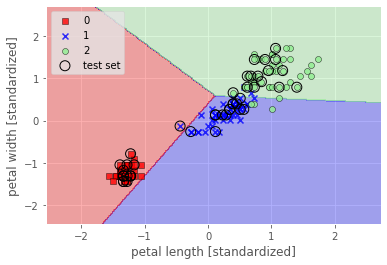

In [10]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std,
                      y = y_combined,
                      classifier = ppn,
                      test_idx = range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc = 'upper left')
plt.show()

## Logistic regression

Logistic regression is a simple and often used method for binary classification that can be extended to multiclass via the OvR technique (similar to the perceptron and Adaline)
The idea behindd logistic regression is predicting the probability that a particular sample belongs to a particular class. It is called the logistic sigmoid function ($\ Z = 1 / (1 + e^-z))$). It takes real numbers als input and transofmres them into values in the range [0,1] with an intercept at $\phi(0) = 0.5$

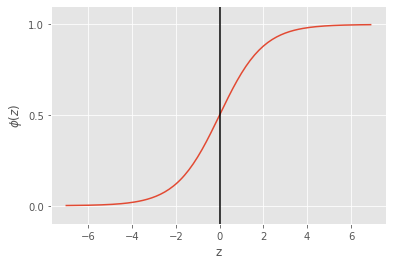

In [12]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))
z = np.arange(-7, 7, 0.1) #example data to plot sigmoid function in range -7 to 7
phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0.0, color = 'k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')
#y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.show()

#### illustration of the cost of classifying a single-sample instance for differenct values of $\phi(z)$

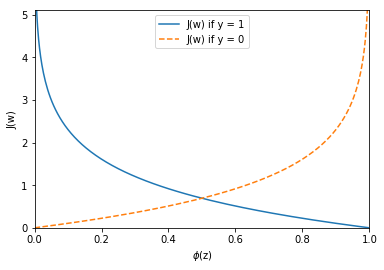

In [11]:
def cost_1(z):
    return - np.log(sigmoid(z))
def cost_0(z):
    return - np.log(1-sigmoid(z))
z = np.arange(-10,10,0.1)
phi_z = sigmoid(z)
c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label = 'J(w) if y = 1')
c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle = '--', label = 'J(w) if y = 0')
plt.ylim(0.0, 5.1)
plt.xlim([0,1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc = 'upper center')
plt.show()

In [12]:
class LogisticRegressionGD(object):
    """"ADAptive LInear NEuron classifier (perceptron with activation function)
    
    Parameters
    -------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles
    random_state : int
      Random number generator seed for random weight initialization
      
    
    Attributes
    -------------
    w_ : 1d-array
      Weights after fitting
    cost_ : list
      Sum-of-squares cost function value averaged over all training samples in each epoch.
      
    """

    def __init__(self, eta=0.01, n_iter = 50, random_state = 1): #Always when creating an class/object; initiate 'self.x'
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
    
        """Fit training data.
        
        Parameters 
        ------------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and n_features is the number of features
        y : array-like, shape = [n_samples]
          Target values
          
        Returns
        ---------
        self : object
        """
    
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc = 0.0, scale = 0.01, size = 1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            #note that we compute the logistics 'cost' now
            #instead of the sum of squared error cost
            
            cost = (-y.dot(np.log(output)) - ((1-y).dot(np.log(1-output))))
            self.cost_.append(cost)
        return self
                            
        
    def net_input(self, X):
        """ Calculate net input """
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """ Compute linear activation """
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        """ Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        #equivalent to
        #return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

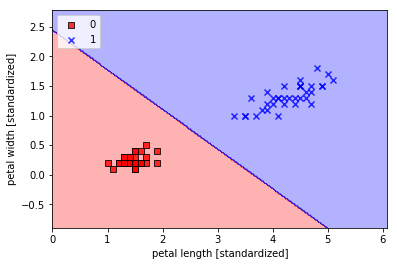

In [13]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train ==0) | (y_train == 1)]
lrgd = LogisticRegressionGD(eta = 0.05, n_iter = 1000, random_state = 1)

lrgd.fit(X_train_01_subset, y_train_01_subset)
plot_decision_regions(X = X_train_01_subset, y = y_train_01_subset, classifier = lrgd)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc = 'upper left')
plt.show()

### implementation of logistic regression with scikit-learn

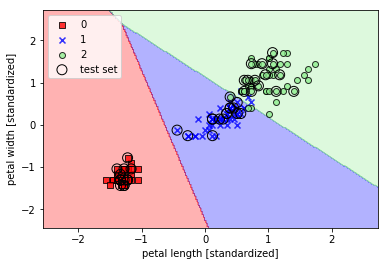

In [14]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C = 100.0, random_state = 1)
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier = lr, test_idx = range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc = 'upper left')
plt.show()

In [15]:
print(lr.predict_proba(X_test_std[:3, :])) #probabilities per class for the first 3 cases (row-wise)
print(lr.predict_proba(X_test_std[:3, :]).argmax(axis = 1)) #max probability per row (and thus most probable class)
print(lr.predict(X_test_std[:3, :])) #Predictions, same output as previous line
#If predictint the class of a single flower, reconversion to a two-dimensional array is necessary for scikit-learn
print(lr.predict(X_test_std[0,:].reshape(1,-1))) #reshape adds an extra dimension


[[3.20136878e-08 1.46953648e-01 8.53046320e-01]
 [8.34428069e-01 1.65571931e-01 4.57896429e-12]
 [8.49182775e-01 1.50817225e-01 4.65678779e-13]]
[2 0 0]
[2 0 0]
[2]


## Tackling overfitting via regularization

Overfitting = high variance
Underfitting = high bias

Regularization is a very useful method to tune the complexity of the model and prevent over/underfitting. It does so by handle collinearity, filter out noise from data by introducing additional information (bios) to penalize extreme parameter (weight) values.

Most often used method is L2-regularization (also called L2 shrinkage or weight decay).
It uses lambda as tunable regularization parameter. In LR the hyperparameter C is the inverse of lambda and the following plot demonstrates the impact of tuning the parameter.

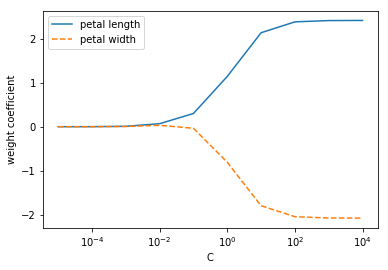

In [16]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C = 10.**c, random_state = 1)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)
weights = np.array(weights)
plt.plot(params, weights[:,0], label= 'petal length')
plt.plot(params, weights[:,1], linestyle = '--', label = 'petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc = 'upper left')
plt.xscale('log')
plt.show()

## Support Vector Machines

An SVM can be considered as an extension of the perceptron, however the objection is to maximize the margin (defined as the distance between the separating hyperplane/decision boundary and the training examples that are closes to this hyperplane (these are called the support vectors)
A large as possible margin is less prone to overfitting. 
Mathematical the equations assume that all negative samples should fall on one side of the hyperplane and all positive cases on the other side.
                                                                                                             
The slack variable was introducted to allow convergence of the optimization in the presence of missclassifications and can be controlled by the hyperparameter C. The larger the value of C, the higher the penalty for misclassification (and the more the hyperplane is trying to classify all samples good).
By this method C can control the bias-variance tradeoff                                                                                                             

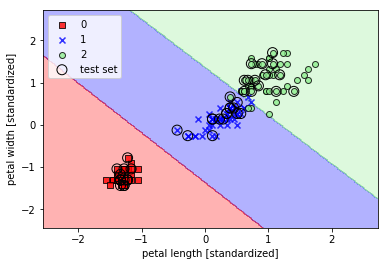

In [17]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear', C = 1.0, random_state = 1)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier = svm, test_idx = range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc = 'upper left')
plt.show()

### Support Vector Machines vs Logistic Regression
SVM and LR often yield similar results
LR is more prone to outliers (as SVM mainly care about the points closest to the hyperplane)
LR is simpler and can be implemented more easily
LR is easily updated and therefore attractive when working with streaming data

#### Note
The used methods to implement logistic regression (LogisticRegression) and SVM's (SVC) are able to learn extremely quick of large amounts of linear classifiers. Sometimes datasets are too larege to fit into compuer memory. Therefore scikit-learn also offers alternative implmentations via the SGDClassifier class, which also supports online learning via partial_fit

In [18]:
from sklearn.linear_model import SGDClassifier
ppn = SGDClassifier(loss = 'perceptron')
lr = SGDClassifier(loss = 'log')
svm = SGDClassifier(loss = 'hinge')

### Nonlinear problems using SVM (Kernels)
Another advantage of an SVM is that it can be easily kernelized and therefore is able to solve nonlinear classification problems.

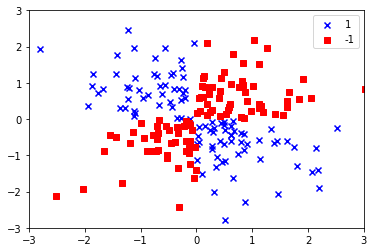

In [19]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)
X_xor = np.random.randn(200,2)
y_xor = np.logical_xor(X_xor[:,0] > 0, X_xor[:,1] > 0)
y_xor = np.where(y_xor, 1, -1)
plt.scatter(X_xor[y_xor == 1, 0],
           X_xor[y_xor == 1, 1],
           c= 'b', marker = 'x', label = '1')
plt.scatter(X_xor[y_xor == -1, 0],
           X_xor[y_xor == -1, 1],
           c= 'r', marker = 's', label = '-1')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.legend(loc = 'best')
plt.show()


A linear hyperplane is not able to seperate the positive and negative samples very well. Kernel methods can deal with such inseperable data by creating nonlinear combinations of the original features to project them onto a higher-dimensional space via a mapping function where it becomes linearly separable.

This mapping function can be used to train a linear SVM model and similarly used to transform new unseen data to classify it using the trained model. This mapping is computationally expensive and therefore we use kernels.
The most used is the Guassian (or Radial Basis Function) kernel.

Roughly speaking the term kernel can be interpreted as a similarity function between a pair of samples.

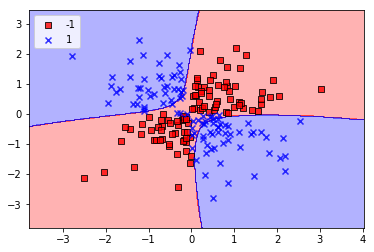

In [20]:
svm = SVC(kernel = 'rbf', random_state = 1, gamma = 0.10, C = 10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier = svm)
plt.legend(loc = 'upper left')
plt.show()

The gamma parameter is a cut-off parameter for the Gaussian spehere, which influences the tightness and bumpyness of the decision boundary

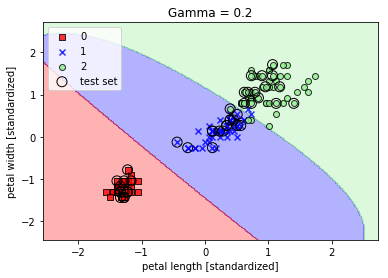

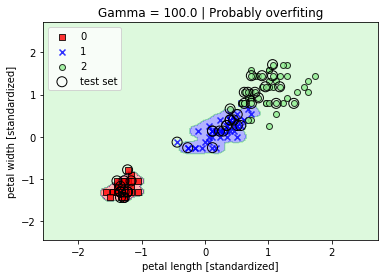

In [21]:
svm = SVC(kernel = 'rbf', random_state = 1, gamma = 0.2, C = 1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier = svm, test_idx = range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc = 'upper left')
plt.title('Gamma = 0.2')
plt.show()


svm = SVC(kernel = 'rbf', random_state = 1, gamma = 100.0, C = 1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier = svm, test_idx = range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc = 'upper left')
plt.title('Gamma = 100.0 | Probably overfiting')
plt.show()

## Decision tree learning

Decision trees are attractive to use if we care about interpretability (we can think of this model by making a decision based on asking a series of questions).
The tree start at the tree root and plits the data on the feature that results in the largest Information Gain (IG). Decision trees are prone to overfitting and therefore often a limit for maximal depth is used.

For simplicity and reduce the combinational search space, most libraries implement binary decision trees. The information gain is the difference between the impurit of the parent node and the sum of the child node impurities.

Three impurity measures are commonly used: Gini impurity, entropy and classification error. Gini and entropy often yield similar results. Entropy attempts to maximize the mutual information in the tree, Gini attempts to minimize the probability of misclassification.
Classification error is also a method, but not recommended as it is less senstiive to changes in the class probabilities of the node.

The following plot shows a visual comparison concluding that Gini is an intermediate measure between entropy and classification error.

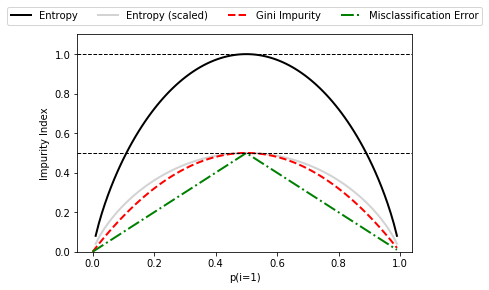

In [22]:
import matplotlib.pyplot as plt
import numpy as np
def gini(p):
    return (p) * (1-(p)) + (1-p)*(1-(1-p))
def entropy(p):
    return - p*np.log2(p) - (1-p)*np.log2((1-p))
def error(p):
    return 1-np.max([p, 1-p])

x = np.arange(0.0,1.0,0.01)
ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]
fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c in zip([ent, sc_ent, gini(x), err],
['Entropy', 'Entropy (scaled)', 'Gini Impurity', 'Misclassification Error'],
['-', '-', '--', '-.'],
['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label = lab, linestyle = ls, lw = 2, color = c)

ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.15), ncol = 5, fancybox = True, shadow = False)
ax.axhline(y = 0.5, linewidth = 1, color = 'k', linestyle = '--')
ax.axhline(y = 1.0, linewidth = 1, color = 'k', linestyle = '--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.show()


Features scaling is not a requirement for decision trees, but can be desired for visualization purposes

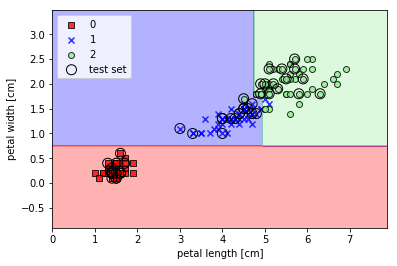

In [23]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 4, random_state = 1)
tree.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, classifier = tree, test_idx = range(105,150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc = 'upper left')
plt.show()

decisiontrees can be exported as a .dot file and visualized by the free GraphViz (http://www.graphiviz.org)

In [24]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
dot_data = export_graphviz(tree,
                          filled = True,
                          rounded = True,
                          class_names=['Setosa',
                                      'Versicolor',
                                      'Virginica'],
                           feature_names=['petal length',
                                         'petal width'],
                           out_file = None)
graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png')

True

## Random Forest

Can be considered as an ensemble of decision trees. The idea is to average multiple (deep) decision trees that invidivudally suffer from high variance, to build amore robust model that has a better performance and is less susceptible for overfitting.
Random forests consist of 4 steps

* Draw a random boostrap sample of size n (randomly choose n samples from the training set with replacement)
* Grow a decision tree form the bootstrap sample at each node
    - Randomly select d features without replacement
    - Split the node useing the feature that provides the best split according to the objective function, for instance maximing the infomration gain
* Repeat steps 1-2 k times
* Aggregate the prediction by each tree to assign the class label by majoiryt vote.

Interpretability of random forests is not as good as for individual decision trees, however, the big advantage is that we don't have to worry so much about choosing good hyperparameter values. No pruning is neede for example. The only important is the number of trees (k) --> Larger number of trees often increases performance of the model at the expense of computational cost. Size of the bootstrap can be edited to control the bias-variance tradeoff and the number of random chosen features, although not oftne used in practice.
The RandomForestClassifier in scikit-learn uses a bootstrap size that is equal to the number of samples in the original training set. The square root of the total number of features is often used as the number of features at each split.

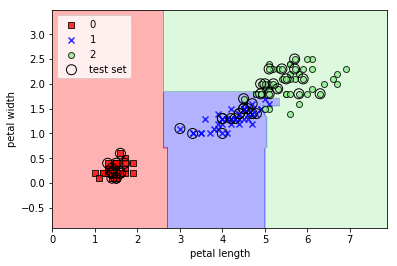

In [26]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion = 'gini',
                               n_estimators = 25,
                               random_state = 1,
                               n_jobs = 2)
forest.fit(X_train, y_train)
plot_decision_regions(X_combined, y_combined, 
                     classifier = forest, test_idx = range(105,150))
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend(loc = 'upper left')
plt.show()

# K-nearest neighbors

Different from the earlier methods. KNN's doen't learn a discriminatieve function from the training data, but rather memorize the training dataset. Can be summarized by the following steps;
* Choose the number k and a distance metric
* Find the k-nearest neigbors of the sample that we want to classify
* Assign the class label by majority vote

The main advantage of KNN's is that the classifier immediatly adapts as we collect new training data. The downside is that the computational complexity for classifying new samples grows linearly with the number of samples in the training dataset. Storage space can become a challenge if working with large datasets

#### Parametric vs. Non-parametric

ML-algorithms can be grouped into para- and non-parametric models. 
* Parametric models estimate parameters from the training dataset to learn a function that can classify new data points withot requiring the original training dataset anymore; Examples are perceptron, logistic regression linear SVM.
* Nonparametric models can't be characterized by a fixed set of parameters and the number of parameters grows with the trainng data; Examples are decision trees, random forest and kernel SVM's.

KNN belof to a subcategory of nonparametric models that is described as instance-based learning. Characterized by memorizing the training dataset.

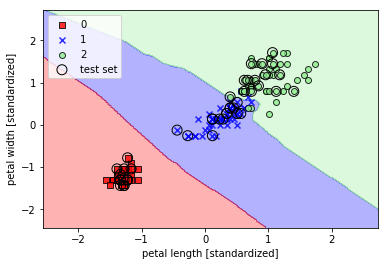

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5, p = 2, metric = 'minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                     classifier = knn, test_idx = range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc = 'upper left')
plt.show()

The right choice of K is crucial for a good over/underfit distance. Setting a distance metric is also important that is appropriate fot eh features in the dataset. Often a simple Euclidean distance measure is used for real-value samples. However, it is important to standardize the data in that case. The minkoswki distance is a generalizatn of the Euclidean and Manhattan distance. It becomes the Euclidean distance when p is set to 2, and the Manhattan distance if p is set to 1.

KNN's are prone to overfitting. Feature selection and dimensionality reduction can help avoid this